# 一、环境依赖

In [11]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.13.1+cu117 True
torchvision version: 0.14.1+cu117
mmpose version: 1.3.2
cuda version: 11.8
compiler information: GCC 7.5


In [3]:
!nvidia-smi

Fri Nov  1 03:29:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:37:00.0 Off |                    0 |
| N/A   29C    P0              37W / 250W |  39244MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 二、inference 

In [2]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

In [4]:
img = '../tests/data/coco/000000197388.jpg'
pose_config = '../configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py'
pose_checkpoint = '../checkpoints/hrnet_w32_coco_256x192-c78dce93_20200708.pth'
det_config = '../demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = '../checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'


device = 'cuda:0'
cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))

# build detector
detector = init_detector(
    det_config,
    det_checkpoint,
    device=device
)


# build pose estimator
pose_estimator = init_pose_estimator(
    pose_config,
    pose_checkpoint,
    device=device,
    cfg_options=cfg_options
)

# init visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

Loads checkpoint by local backend from path: ../checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by local backend from path: ../checkpoints/hrnet_w32_coco_256x192-c78dce93_20200708.pth


/root/project/research/action/mmpose/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco.py" does not exist. A matched config file "/root/project/research/action/mmpose/mmpose/.mim/configs/_base_/datasets/coco.py" will be used instead.
  warnings.warn(


In [5]:

def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    # predict bbox
    scope = detector.cfg.get('default_scope', 'mmdet')
    if scope is not None:
        init_default_scope(scope)
    detect_result = inference_detector(detector, img_path)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    img = mmcv.imread(img_path, channel_order='rgb')

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

In [6]:
visualize_img(
    img,
    detector,
    pose_estimator,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()

11/01 03:29:39 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
11/01 03:29:43 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".
------------------ bboxes: [[  0.       41.83992  87.01635 270.15488]
 [161.40358  89.95338 368.12274 335.16513]
 [535.98553  49.71124 640.      263.9415 ]
 [374.1488  182.63237 633.45154 387.96625]
 [280.14655  58.17254 363.1896  143.65933]]


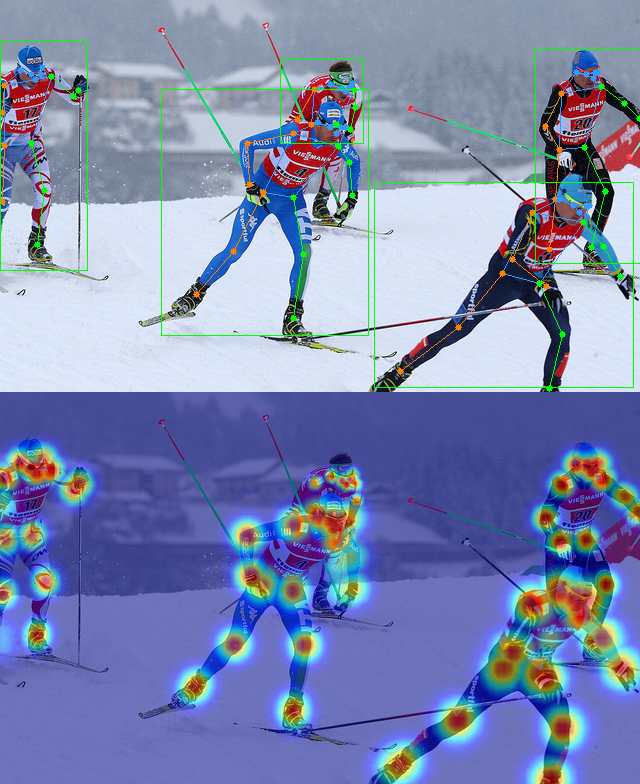

In [7]:
if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    import cv2
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join(tmpdir, 'pose_results.png')
        cv2.imwrite(file_name, vis_result[:,:,::-1])
        display(Image(file_name))
else:
    cv2_imshow(vis_result[:,:,::-1]) #RGB2BGR to fit cv2

In [9]:
# download dataset
# %mkdir data
# %cd data
# !wget https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar
# !tar -xf coco_tiny.tar
# %cd ..

In [43]:
!tree /root/dataset/action/coco_tiny -L 1
"""
在 COCO 数据集的关键点标注中，visibility 表示关键点的可见性状态，通常是一个整数值，具体含义如下：

0：关键点不可见且未标注（例如在图像中被遮挡或不在图像中）。
1：关键点不可见但已标注（例如被遮挡，但标注者知道它的位置）。
2：关键点可见且已标注。
"""

/root/dataset/action/coco_tiny
├── anno
├── images
├── train.json
└── val.json

2 directories, 2 files


'\n在 COCO 数据集的关键点标注中，visibility 表示关键点的可见性状态，通常是一个整数值，具体含义如下：\n\n0：关键点不可见且未标注（例如在图像中被遮挡或不在图像中）。\n1：关键点不可见但已标注（例如被遮挡，但标注者知道它的位置）。\n2：关键点可见且已标注。\n'

In [39]:
import os
import json
from labelme import utils

def coco_to_labelme(coco_json_path, output_dir):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    images_list = []
    annotations_list = []
    image_num = -1
    # print(f"coco_data: {coco_data}")
    for annotation  in coco_data:
        # 获取图像文件名和大小
        image_file = annotation['image_file']
        if image_file == "000000019157.jpg":
            print(f"annotation: {annotation}")
        image_size = annotation['image_size']
        image_height, image_width = image_size[0], image_size[1]
        
        # 获取边界框 (bbox) 和关键点 (keypoints)
        bbox = annotation['bbox']
        keypoints = annotation['keypoints']
        
        # 创建 Labelme 格式的 JSON 文件结构
        labelme_data = {
            "version": "5.5.0",
            "flags": {},
            "shapes": [],
            "imagePath": image_file,
            'imageData': None,
            "imageHeight": image_height,
            "imageWidth": image_width
        }

        # 添加边界框 (rectangle) 的标注
        x, y, width, height = bbox
        rectangle_shape = {
            "label": "person",
            "points": [
                [x, y],
                [x + width, y + height]
            ],
            "group_id": None,
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "mask": None
        }
        labelme_data["shapes"].append(rectangle_shape)

        # 添加关键点 (points) 的标注
        for i in range(0, len(keypoints), 3):
            kp_x, kp_y, visibility = keypoints[i], keypoints[i+1], keypoints[i+2]
            if visibility > 0:  # visibility 大于0表示可见的关键点
                point_shape = {
                    "label": str(i // 3 + 1),
                    "points": [[kp_x, kp_y]],
                    "group_id": None,
                    "description": "",
                    "shape_type": "point",
                    "flags": {},
                    "mask": None
                }
                labelme_data["shapes"].append(point_shape)
        
        # 保存 Labelme JSON 文件
        output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}.json")
        with open(output_path, 'w') as f:
            json.dump(labelme_data, f, indent=2)
        print(f"Saved: {output_path}")



In [40]:
out_dir =  "/root/dataset/action/coco_tiny/anno/val/"
os.makedirs(out_dir, exist_ok=True)
coco_to_labelme('/root/dataset/action/coco_tiny/val.json', out_dir)

Saved: /root/dataset/action/coco_tiny/anno/val/000000103163.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000083935.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000390137.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000515289.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000019608.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000388619.json
annotation: {'image_file': '000000019157.jpg', 'image_size': [640, 456], 'bbox': [4.65, 114.11, 152.29, 315.3], 'keypoints': [86, 146, 2, 0, 0, 0, 74, 144, 2, 0, 0, 0, 57, 145, 2, 110, 161, 2, 26, 179, 2, 145, 170, 2, 11, 229, 2, 147, 175, 2, 48, 247, 2, 111, 248, 2, 64, 257, 2, 119, 328, 2, 69, 335, 2, 135, 395, 2, 79, 398, 2]}
Saved: /root/dataset/action/coco_tiny/anno/val/000000019157.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000175737.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000362343.json
Saved: /root/dataset/action/coco_tiny/anno/val/000000568961.json
Saved: /root/datase

# 三、train

In [46]:
# check the annotation format
import json
import pprint

anns = json.load(open('/root/dataset/action/coco_tiny/train.json'))

print(type(anns), len(anns))
pprint.pprint(anns[0], compact=True)

<class 'list'> 75
{'bbox': [267.03, 104.32, 229.19, 320],
 'image_file': '000000537548.jpg',
 'image_size': [640, 480],
 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 160, 2, 398,
               177, 2, 0, 0, 0, 437, 238, 2, 0, 0, 0, 477, 270, 2, 287, 255, 1,
               339, 267, 2, 0, 0, 0, 423, 314, 2, 0, 0, 0, 355, 367, 2]}


## TinyCocoDataset

In [47]:
# Copyright (c) OpenMMLab. All rights reserved.
import json
import os.path as osp
from typing import Callable, List, Optional, Sequence, Union

import numpy as np
from mmengine.utils import check_file_exist

from mmpose.registry import DATASETS
from mmpose.datasets.datasets.base import BaseCocoStyleDataset


@DATASETS.register_module()
class TinyCocoDataset(BaseCocoStyleDataset):
    METAINFO: dict = dict(from_file='../configs/_base_/datasets/coco.py')

    def _load_annotations(self) -> List[dict]:
        """Load data from annotations in MPII format."""

        check_file_exist(self.ann_file)
        with open(self.ann_file) as anno_file:
            anns = json.load(anno_file)

        data_list = []
        ann_id = 0

        for idx, ann in enumerate(anns):
            img_h, img_w = ann['image_size']

            # get bbox in shape [1, 4], formatted as xywh
            x, y, w, h = ann['bbox']
            x1 = np.clip(x, 0, img_w - 1)
            y1 = np.clip(y, 0, img_h - 1)
            x2 = np.clip(x + w, 0, img_w - 1)
            y2 = np.clip(y + h, 0, img_h - 1)

            bbox = np.array([x1, y1, x2, y2], dtype=np.float32).reshape(1, 4)

            # load keypoints in shape [1, K, 2] and keypoints_visible in [1, K]
            joints_3d = np.array(ann['keypoints']).reshape(1, -1, 3)
            num_joints = joints_3d.shape[1]
            keypoints = np.zeros((1, num_joints, 2), dtype=np.float32)
            keypoints[:, :, :2] = joints_3d[:, :, :2]
            keypoints_visible = np.minimum(1, joints_3d[:, :, 2:3])
            keypoints_visible = keypoints_visible.reshape(1, -1)

            data_info = {
                'id': ann_id,
                'img_id': int(ann['image_file'].split('.')[0]),
                'img_path': osp.join(self.data_prefix['img'], ann['image_file']),
                'bbox': bbox,
                'bbox_score': np.ones(1, dtype=np.float32),
                'keypoints': keypoints,
                'keypoints_visible': keypoints_visible,
            }

            data_list.append(data_info)
            ann_id = ann_id + 1

        return data_list, None


## config

In [64]:
from mmengine import Config

cfg = Config.fromfile(
    '../configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py'
)

# set basic configs
cfg.data_root = '/root/dataset/action/coco_tiny'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
cfg.randomness = dict(seed=0)

# set log interval
cfg.train_cfg.val_interval = 1

# set num of epoch
cfg.train_cfg.max_epochs = 40

# set optimizer
cfg.optim_wrapper = dict(optimizer=dict(
    type='Adam',
    lr=5e-4,
))

# set learning rate policy
cfg.param_scheduler = [
    dict(
        type='LinearLR', begin=0, end=10, start_factor=0.001,
        by_epoch=False),  # warm-up
    dict(
        type='MultiStepLR',
        begin=0,
        end=cfg.train_cfg.max_epochs,
        milestones=[17, 35],
        gamma=0.1,
        by_epoch=True)
]


# set batch size
cfg.train_dataloader.batch_size = 16
cfg.val_dataloader.batch_size = 16
cfg.test_dataloader.batch_size = 16

# set dataset configs
cfg.dataset_type = 'TinyCocoDataset'
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.ann_file = 'train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img='images/')


cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.bbox_file = None
cfg.val_dataloader.dataset.ann_file = 'val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img='images/')

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.bbox_file = None
cfg.test_dataloader.dataset.ann_file = 'val.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img='images/')

# set evaluator
cfg.val_evaluator = dict(type='PCKAccuracy')
cfg.test_evaluator = cfg.val_evaluator

cfg.default_hooks.checkpoint.save_best = 'PCK'
cfg.default_hooks.checkpoint.max_keep_ckpts = 1

cfg.model.backbone.init_cfg.checkpoint = "../checkpoints/hrnet_w32-36af842e.pth"

print(cfg.pretty_text)


auto_scale_lr = dict(base_batch_size=512)
backend_args = dict(backend='local')
codec = dict(
    heatmap_size=(
        48,
        64,
    ),
    input_size=(
        192,
        256,
    ),
    sigma=2,
    type='MSRAHeatmap')
custom_hooks = [
    dict(type='SyncBuffersHook'),
]
data_mode = 'topdown'
data_root = '/root/dataset/action/coco_tiny'
dataset_type = 'TinyCocoDataset'
default_hooks = dict(
    badcase=dict(
        badcase_thr=5,
        enable=False,
        metric_type='loss',
        out_dir='badcase',
        type='BadCaseAnalysisHook'),
    checkpoint=dict(
        interval=10,
        max_keep_ckpts=1,
        rule='greater',
        save_best='PCK',
        type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(enable=False, type='PoseVisualizationHook'))
default_scope = 'mmpose'
env_cfg

In [65]:
cfg.model.backbone.init_cfg.checkpoint

'../checkpoints/hrnet_w32-36af842e.pth'

## train

In [66]:
from mmengine.config import Config, DictAction
from mmengine.runner import Runner

# set preprocess configs to model
cfg.model.setdefault('data_preprocessor', cfg.get('preprocess_cfg', {}))

# build the runner from config
runner = Runner.from_cfg(cfg)

# start training
runner.train()

11/05 01:11:07 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA A100-PCIE-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=co

/root/conda/envs/cv_env/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


11/05 01:11:07 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
11/05 01:11:07 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

TopdownPoseEstimator(
  (data_preprocessor): PoseDataPreprocessor()
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm